In [1]:
#librerie necessarie per la classificazione
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score


C:\Users\Martina\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import itertools    
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Oranges):
        import itertools
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [3]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
#open file
df = pd.read_csv('abalone-data.csv')

In [5]:
#rename columns
df.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

In [6]:
#discard the “Infant” abalones
df = df[df['Sex'] != 'I' ]

In [7]:
# Generate a mapping of Sex from a string to a number representation    
sexes = sorted(df['Sex'].unique()) #Return unique values 
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1))) #create a dictionary {F: number of records; M: number of records}
# Transform Sex from a string to a number representation
df['Sex'] = df['Sex'].map(genders_mapping).astype(int) #Male=1; Female=0

In [8]:
#copia df per dati sbilanciati
df_imb = df.copy()

In [9]:
#copia df per dati oversampled
df_os = df.copy()

In [10]:
#classi bilanciate
df['Bin'] = pd.cut(df['Rings'], bins=[0, 10, 29], right=True, labels = [0, 1] )

In [11]:
#classi sbilanciate
df_imb['Bin'] = pd.cut(df_imb['Rings'], bins=[0, 14, 29], right=True, labels = [0, 1] ) 
print(df_imb.Bin.value_counts(sort=True)*100/len(df_imb)) 
df_imb = df_imb.drop(['Rings'], axis=1)

0    88.359788
1    11.640212
Name: Bin, dtype: float64


In [12]:
#classi oversampled
df_os['Bin'] = pd.cut(df_os['Rings'], bins=[0, 14, 29], right=True, labels = [0, 1] ) 
print(df_os.Bin.value_counts(sort=True)*100/len(df_os)) 
df_os = df_os.drop(['Rings'], axis=1)

0    88.359788
1    11.640212
Name: Bin, dtype: float64


In [13]:
df = df.drop(labels= ['Rings'], axis = 1)

In [14]:
train_data = df.values
train_features = train_data[:, 0:7]

In [15]:
train_target = train_data[:,8].astype('int')

In [16]:
x_train, x_test, y_train, y_test = train_test_split(train_features, train_target, test_size = 0.20, random_state = 0)

# ADABOOST - CLASSI BILANCIATE

In [17]:
#stima del classificatore ad albero
clf = DecisionTreeClassifier()

parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,None] ,
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'], 
              'min_samples_split': [2,3,4,5], 
              'min_samples_leaf': [2,3,4,5], 
              'min_weight_fraction_leaf': [0.0,0.1,0.2]
             }
scorer = make_scorer(accuracy_score)

In [18]:
grid_search = GridSearchCV(clf, param_grid = parameters, scoring=scorer)

In [19]:
grid_fit = grid_search.fit(x_train,y_train)

In [20]:
print ('I migliori parametri dopo la Grid Search sono:', grid_fit.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'splitter': 'best', 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 6})


In [21]:
clf.set_params(splitter='best', min_samples_leaf=5, min_weight_fraction_leaf=0.0, criterion='gini', min_samples_split= 2, max_depth=6)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
clf = clf.fit(x_train, y_train);

In [23]:
predictions = clf.predict(x_test)

In [24]:
scores = cross_validation.cross_val_score(clf, x_train, y_train, cv=5)
print ('Accuracy balanced classes: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy balanced classes: 0.67 (+/- 0.04)


In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator=clf)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

param = {'learning_rate': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
         'n_estimators': [50, 100, 150, 200, 225, 250], 
         'algorithm' : ['SAMME', 'SAMME.R']
        }

In [26]:
grid_ada = GridSearchCV(ada, param_grid = param, scoring=scoring, cv=5, refit='AUC')

In [28]:
grid_a = grid_ada.fit(x_train,y_train)

In [29]:
print ('I migliori parametri dopo la Grid Search sono:', grid_a.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'n_estimators': 150, 'learning_rate': 0.5, 'algorithm': 'SAMME'})


In [30]:
ada.set_params(learning_rate=0.5, n_estimators=150, algorithm='SAMME')

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=150, random_state=None)

In [31]:
ada = ada.fit(x_train, y_train);

In [32]:
test_pred = ada.predict(x_test)

In [105]:
print("Accuracy on test set: ", round(metrics.accuracy_score(y_test, test_pred),3))

('Accuracy on training set:', 0.781)
('Accuracy on test set: ', 0.744)


In [ ]:
scores = cross_validation.cross_val_score(clf, x_train, y_train, cv=5)
print ('Accuracy balanced classes: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

In [111]:
# examine the class distribution of the testing set
unique, counts = numpy.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 299, 1: 268}

In [113]:
#CLASSI BILANCIATE
classes= ['3-10', '11-29']
cm_test = confusion_matrix(y_test, test_pred)

Confusion matrix, without normalization
[[244  55]
 [ 90 178]]


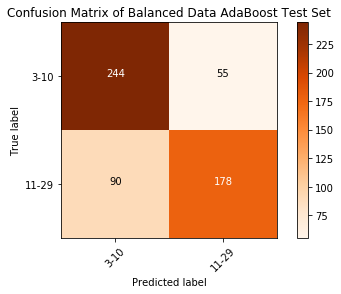

In [116]:
#Test set
plot_confusion_matrix(cm_test, classes=classes, title="Confusion Matrix of Balanced Data AdaBoost Test Set")

# ADABOOST - CLASSI SBILANCIATE

In [33]:
train_data_imb = df_imb.values
train_features_imb = train_data_imb[:, 0:7]

In [34]:
train_target_imb = train_data_imb[:,8].astype('int')

In [35]:
x_train_imb, x_test_imb, y_train_imb, y_test_imb = train_test_split(train_features_imb, train_target_imb, test_size = 0.20, random_state = 0)

In [36]:
#stima del classificatore ad albero
clf_imb = DecisionTreeClassifier()

parameters_imb = {'max_depth':[1,2,3,4,5,6,7,8,9,10,None] ,
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'], 
              'min_samples_split': [0.1,0.2,0.3,0.4,0.5], 
              'min_samples_leaf': [1,2,3,4,5,6,7], 
              'min_weight_fraction_leaf': [0.0,0.1,0.2]
             }
scorer = make_scorer(accuracy_score)

In [37]:
grid_search_imb = GridSearchCV(clf_imb, param_grid = parameters_imb, scoring=scorer)

In [38]:
grid_fit_imb = grid_search_imb.fit(x_train_imb,y_train_imb)

In [39]:
print ('I migliori parametri dopo la Grid Search sono:', grid_fit_imb.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'splitter': 'random', 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'min_samples_split': 0.1, 'max_depth': 5})


In [40]:
clf_imb.set_params(splitter='random', min_samples_leaf=7, min_weight_fraction_leaf=0.0, criterion='gini', min_samples_split= 0.1, max_depth=5)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

In [41]:
clf_imb = clf_imb.fit(x_train_imb, y_train_imb);

In [42]:
predictions_imb = clf_imb.predict(x_test_imb)

In [43]:
scores = cross_validation.cross_val_score(clf_imb, x_train_imb, y_train_imb, cv=5)
print ('Accuracy DT unbalanced classes: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() * 2))

Accuracy unbalanced classes: 0.88669 (+/- 0.00578)


In [44]:
accuracy_grid = accuracy_score(y_test_imb, predictions_imb)*100
print(round(accuracy_grid, 2), '%')

(86.6, '%')


In [45]:
from sklearn.ensemble import AdaBoostClassifier

ada_imb = AdaBoostClassifier(base_estimator=clf_imb)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

param = {'learning_rate': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
         'n_estimators': [50, 100, 150, 200, 225, 250], 
         'algorithm' : ['SAMME', 'SAMME.R']
        }

In [46]:
grid_ada_imb = GridSearchCV(ada_imb, param_grid = param, scoring=scoring, cv=5, refit='AUC')

In [47]:
grid_a_imb = grid_ada_imb.fit(x_train_imb,y_train_imb)

In [48]:
print ('I migliori parametri dopo la Grid Search sono:', grid_a_imb.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'n_estimators': 150, 'learning_rate': 0.5, 'algorithm': 'SAMME'})


In [49]:
ada_imb.set_params(learning_rate=0.5, n_estimators=150, algorithm='SAMME')

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.5, n_estimators=150, random_state=None)

In [50]:
ada_imb = ada_imb.fit(x_train_imb, y_train_imb);

In [51]:
test_pred_imb = ada_imb.predict(x_test_imb)

In [52]:
scores = cross_validation.cross_val_score(clf_imb, x_train_imb, y_train_imb, cv=5)
print ('Accuracy AdaBoost unbalanced classes: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() * 2))

Accuracy AdaBoost unbalanced classes: 0.88625 (+/- 0.00751)


In [53]:
# examine the class distribution of the testing set
unique, counts = np.unique(y_test_imb, return_counts=True)
dict(zip(unique, counts))

{0: 491, 1: 76}

In [58]:
classes= ['3-14', '15-29']
cm_test_imb = confusion_matrix(y_test_imb, test_pred_imb)

Confusion matrix, without normalization
[[478  13]
 [ 54  22]]


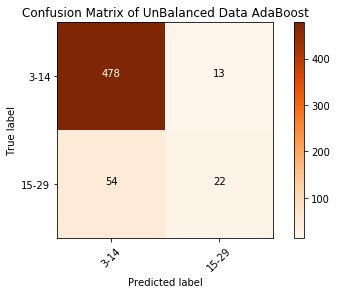

In [59]:
#Test set
plot_confusion_matrix(cm_test_imb, classes=classes, title="Confusion Matrix of UnBalanced Data AdaBoost")

# ADABOOST - OVERSAMPLED

In [60]:
train_data_os = df_os.values
train_features_os = train_data_os[:, 0:7]

In [61]:
train_target_os = train_data_os[:,8].astype('int')

In [62]:
#OVERSAMPLING SULLA CLASSE DI MINORANZA (15-29)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [63]:
sm = SMOTE(ratio = {1:1800})
trainfSMO, traintSMO = sm.fit_sample(train_features_os, train_target_os)

In [64]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(trainfSMO, traintSMO, test_size = 0.20, random_state = 0)

In [65]:
#stima del classificatore ad albero
clf_os = DecisionTreeClassifier()

parameters_os = {'max_depth':[1,2,3,4,5,6,7,8,9,10,None] ,
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'], 
              'min_samples_split': [0.1,0.2,0.3,0.4,0.5], 
              'min_samples_leaf': [1,2,3,4,5,6,7], 
              'min_weight_fraction_leaf': [0.0,0.1,0.2]
             }
scorer = make_scorer(accuracy_score)

In [66]:
grid_search_os = GridSearchCV(clf_os, param_grid = parameters_os, scoring=scorer)

In [67]:
grid_fit_imb = grid_search_os.fit(x_train_os,y_train_os)

In [68]:
print ('I migliori parametri dopo la Grid Search sono:', grid_fit_imb.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'splitter': 'best', 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'min_samples_split': 0.1, 'max_depth': 7})


In [69]:
clf_os.set_params(splitter='best', min_samples_leaf=1, min_weight_fraction_leaf=0.0, criterion='entropy', min_samples_split= 0.1, max_depth=7)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [70]:
clf_os = clf_os.fit(x_train_os, y_train_os);

In [71]:
predictions_imb = clf_os.predict(x_test_os)

In [72]:
scores = cross_validation.cross_val_score(clf_os, x_train_os, y_train_os, cv=5)
print ('Accuracy DT oversampled classes: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() * 2))

Accuracy DT oversampled classes: 0.75580 (+/- 0.04435)


In [73]:
accuracy_grid = accuracy_score(y_test_os, predictions_imb)*100
print(round(accuracy_grid, 2), '%')

(79.79, '%')


In [77]:
from sklearn.ensemble import AdaBoostClassifier

ada_os = AdaBoostClassifier(base_estimator=clf_os)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

param = {'learning_rate': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
         'n_estimators': [50, 100, 150, 200, 225, 250], 
         'algorithm' : ['SAMME', 'SAMME.R']
        }

In [78]:
grid_ada_os = GridSearchCV(ada_os, param_grid = param, scoring=scoring, refit='AUC')

In [79]:
grid_a_os = grid_ada_os.fit(x_train_os,y_train_os)

In [80]:
print ('I migliori parametri dopo la Grid Search sono:', grid_a_os.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'n_estimators': 250, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'})


In [81]:
ada_os.set_params(learning_rate=1.0, n_estimators=250, algorithm='SAMME.R')

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=250, random_state=None)

In [82]:
ada_os = ada_os.fit(x_train_os, y_train_os);

In [83]:
test_pred_os = ada_os.predict(x_test_os)

In [84]:
scores = cross_validation.cross_val_score(clf_os, x_train_os, y_train_os, cv=5)
print ('Accuracy AdaBoost oversampled classes: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() * 2))

Accuracy AdaBoost oversampled classes: 0.75580 (+/- 0.04435)


In [87]:
print("Accuracy Oversampled ", round(metrics.accuracy_score(y_test_os, test_pred_os)*100, 2), '%')

('Accuracy Oversampled ', 90.01, '%')


In [89]:
classes= ['3-14', '15-29']
cm_test_os = confusion_matrix(y_test_os, test_pred_os)

Confusion matrix, without normalization
[[457  50]
 [ 36 318]]


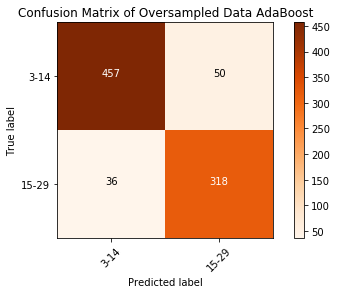

In [90]:
#Test set
plot_confusion_matrix(cm_test_os, classes=classes, title="Confusion Matrix of Oversampled Data AdaBoost")

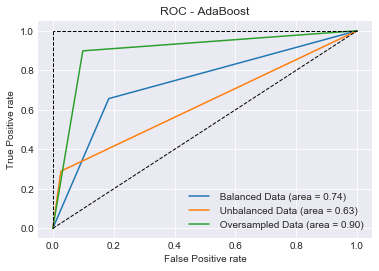

In [91]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

fpr_test, tpr_test, _= roc_curve(y_test, test_pred)
roc_auc = auc(fpr_test, tpr_test)


fpr_test_imb, tpr_test_imb, _= roc_curve(y_test_imb, test_pred_imb)
roc_auc_imb = auc(fpr_test_imb, tpr_test_imb)


fpr_test_os, tpr_test_os, _= roc_curve(y_test_os, test_pred_os)
roc_auc_os = auc(fpr_test_os, tpr_test_os)



sns.set_style("darkgrid")
plt.plot(fpr_test,tpr_test, label=' Balanced Data (area = %0.2f)' % roc_auc)
plt.plot(fpr_test_imb,tpr_test_imb, label=' Unbalanced Data (area = %0.2f)' % roc_auc_imb)
plt.plot(fpr_test_os,tpr_test_os, label=' Oversampled Data (area = %0.2f)' % roc_auc_os)

plt.title("ROC - AdaBoost")

plt.legend(loc="lower right")
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate');
plt.show()